In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange

/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

# Workflow starts here!

In [3]:
###################### need to change start
ipts="29313"
###################### need to change end

## Find CT scan location

In [4]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_loc)

['2022_10_14_high_res_0_180',
 '2022_10_14_high_res',
 '2022_10_13_set2',
 '2022_10_13_set1',
 '2022_10_12_set1']

## Find OB location

In [5]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2022_10_14_high_res', '2022_10_13_set2', '2022_10_12']

## Find DC location

In [6]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2022_10_14_high_res', '2022_10_13_set2', '2022_10_10']

In [7]:
###################### need to change start
sample_name = "2022_10_13_set1"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_10_12")
dc_dir = os.path.join(dc_loc, "2022_10_10")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
###################### need to change end

# Load all data files (CT, OB and DC)

Found index of 180 degree projections:  581
Loading CT projections...
Loading CT projections...Done!
(1162, 2048, 2048)


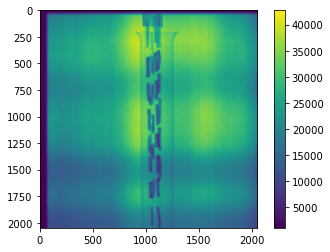

Loading Open Beam (OB)...
Loading Open Beam (OB)...Done!
(5, 2048, 2048)


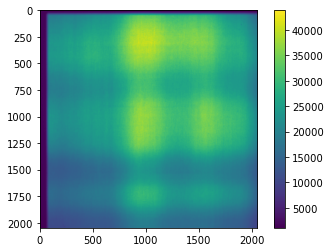

Loading Dark Current (DC)...
Loading Dark Current (DC)...Done!
(5, 2048, 2048)


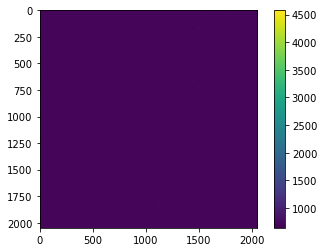

In [8]:
######### CT
proj_raw, theta, proj180_ind = rocku.load_ct(ct_dir, ang2=360, name="raw*")
print(proj_raw.shape)
plt.imshow(proj_raw[0])
plt.colorbar()
plt.show()
######### OB
ob_raw = rocku.load_ob(ob_dir, name="ob*")
print(ob_raw.shape)
plt.imshow(ob_raw[0])
plt.colorbar()
plt.show()
######### DC
dc_raw = rocku.load_dc(dc_dir, name="df*")
print(dc_raw.shape)
plt.imshow(dc_raw[0])
plt.colorbar()
plt.show()

# Define/crop ROI
## a. Auto detect and crop the slits

Slit corners: 
 [[  53   18]
 [  53 1843]
 [1616 1843]
 [1616   18]]
Projection at 0 degree:


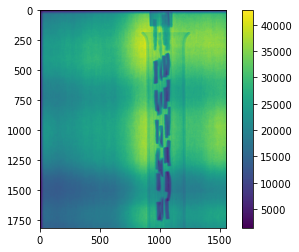

Projection at 180 degree:


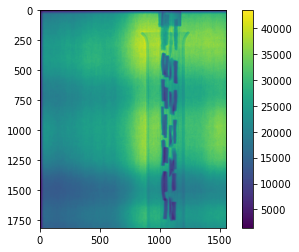

In [9]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob_raw[0], method='simple')
print("Slit corners: \n", slit_box_corners)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj_raw, slit_box_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob_raw, slit_box_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc_raw, slit_box_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.colorbar()
plt.show()

## b. Define the ROI by corners

Projection at 0 degree:


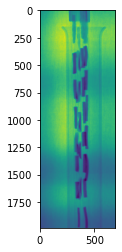

Projection at 180 degree:


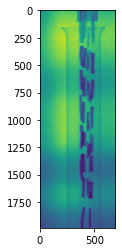

In [10]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob_raw[0], method='simple')
roi_corners = rocku.set_roi(corners=slit_box_corners, xmin=700, ymin=50, xmax=1400, ymax=2047)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj_raw, roi_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob_raw, roi_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc_raw, roi_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.show()

# Remove Outliers

In [11]:
diff = 50
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, diff)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, diff)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, diff)

# Normalization

float32


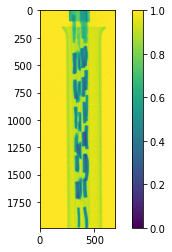

In [12]:
ob_med = np.median(ob_crop, axis=0).astype(np.ushort)
dc_med = np.median(dc_crop, axis=0).astype(np.ushort)
ob = ob_med - dc_med
proj = proj_crop - dc_med
proj_norm = np.true_divide(proj, ob)
print(proj_norm.dtype)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)

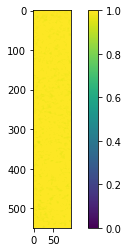

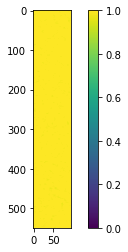

In [13]:
bg_roi = [1000, 5, 1550, 100] # [ymin, xmin, ymax, xmax]
bg_stack = proj_norm[:, bg_roi[0]:bg_roi[2], bg_roi[1]:bg_roi[3]] 
plt.imshow(bg_stack[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(bg_stack[proj180_ind], vmin=0, vmax=1)
plt.colorbar()
plt.show()

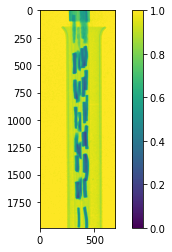

In [14]:
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi=bg_roi) #[ymin, xmin, ymax, xmax]
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Filter NaN and negative

In [15]:
proj_norm = tomopy.remove_nan(proj_norm)
proj_norm = tomopy.remove_neg(proj_norm)

# Minus log conversion

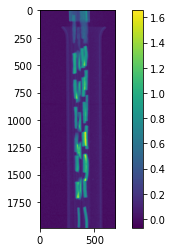

In [16]:
proj_mlog = tomopy.minus_log(proj_norm)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Remove Outliers

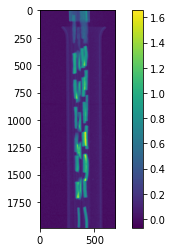

In [17]:
proj_mlog_filter = tomopy.remove_outlier(proj_mlog, diff)
plt.imshow(proj_mlog_filter[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


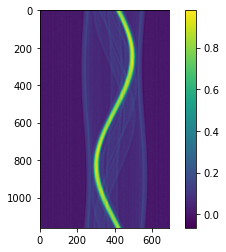

After ring removal:


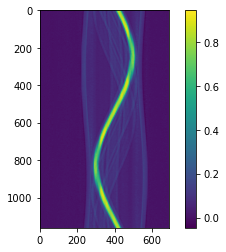

In [18]:
proj_rmv = rocku.remove_ring(proj_mlog_filter, algorithm="Vo")
############## bm3d, slightly better, but slow
# proj_rmv = rocku.remove_ring(proj_mlog_filter, algorithm="bm3d")
print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 600, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 600, :])
plt.colorbar()
plt.show()

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Denoising sinogram 0
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 12
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 13
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 14
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 15
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 16
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 17
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 18
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 19
k: 4


k: 3
k: 2
k: 1
k: 0
Denoising sinogram 172
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 173
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 174
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 175
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 176
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 177
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 178
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 179
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 180
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 181
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 182
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 183
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 184
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 185
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 186
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 187
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 188
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 189
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 190
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 191
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 343
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 344
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 345
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 346
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 347
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 348
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 349
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 350
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 351
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 352
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 353
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 354
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 355
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 356
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 357
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 358
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 359
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 360
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 361
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 362
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 514
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 515
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 516
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 517
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 518
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 519
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 520
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 521
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 522
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 523
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 524
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 525
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 526
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 527
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 529
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 530
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 531
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 532
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 533
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 685
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 686
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 687
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 688
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 689
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 690
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 691
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 692
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 693
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 694
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 700
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 701
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 702
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 703
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 704
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 856
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 857
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 858
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 859
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 860
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 861
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 862
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 863
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 864
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 865
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 866
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 867
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 868
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 869
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 870
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 871
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 872
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 873
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 874
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 875
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8

k: 1
k: 0
Denoising sinogram 1026
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1027
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1028
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1029
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1030
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1031
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1032
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1033
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1034
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1035
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1036
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1037
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1038
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1039
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1040
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1041
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1042
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1043
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1044
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1045
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising 

Denoising sinogram 1193
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1194
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1195
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1196
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1197
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1198
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1199
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1200
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1201
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1202
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1203
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1204
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1205
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1206
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1207
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1208
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1209
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1210
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1211
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1212
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1361
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1362
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1363
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1364
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1365
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1366
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1367
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1368
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1369
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1370
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1371
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1372
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1373
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1374
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1375
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1376
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1377
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1378
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1379
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1380
k: 4
k: 3
k: 2
k: 1
k: 0


k: 1
k: 0
Denoising sinogram 1528
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1529
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1530
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1531
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1532
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1533
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1534
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1535
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1536
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1537
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1538
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1539
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1540
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1541
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1542
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1543
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1544
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1545
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1546
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1547
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising 

Denoising sinogram 1695
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1696
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1697
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1698
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1699
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1700
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1701
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1702
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1703
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1704
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1705
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1706
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1707
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1708
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1709
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1710
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1711
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1712
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1713
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1714
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1863
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1864
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1865
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1866
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1867
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1868
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1869
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1870
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1871
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1872
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1873
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1874
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1875
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1876
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1877
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1878
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1879
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1880
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1881
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1882
k: 4
k: 3
k: 2
k: 1
k: 0


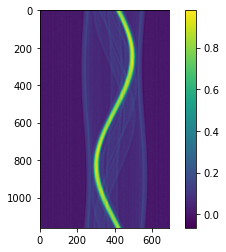

After ring removal:


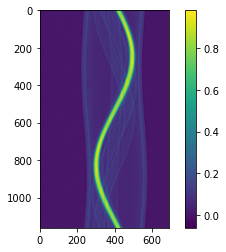

In [25]:
# proj_rmv = rocku.remove_ring(proj_mlog_filter, algorithm="Vo")
############## bm3d, slightly better, but slow
proj_rmv = rocku.remove_ring(proj_mlog_filter, algorithm="bm3d")
print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 600, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 600, :])
plt.colorbar()
plt.show()

# Export proj files (optional)

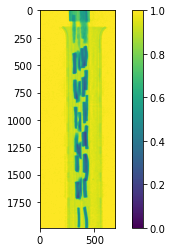

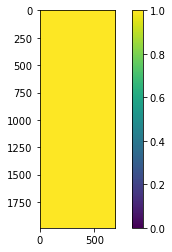

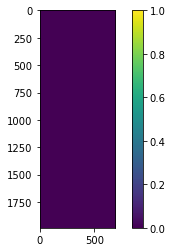

In [41]:
proj_output = proj_rmv.astype(np.float32)
proj_output = np.exp(-1 * proj_output) # convert back to transmission
ob_output = np.ones((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
dc_output = np.zeros((proj_output.shape[1],proj_output.shape[2]), dtype=proj_output.dtype)
plt.imshow(proj_output[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(ob_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(dc_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [42]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name # + "_vo"
dxchange.write_tiff_stack(proj_output, fname=save_to + "/raw", overwrite=True)
dxchange.write_tiff(ob_output, fname=save_to + '/ob')
dxchange.write_tiff(dc_output, fname=save_to + '/dc')

# Find and correct tilt

Finding the tilt angle...
Found the tilt angle:  0.19215599223857918


/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3d/filters/tilt.py:115: TqdmWarning: Iterable length 1162 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
Applying tilt corr: 100%|███████████████████| 1162/1162 [00:21<00:00, 54.47it/s]


Projection at 0 degree:


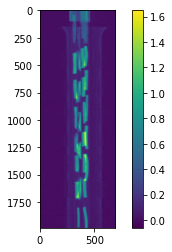

Projection at 180 degree:


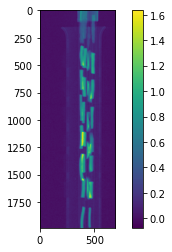

In [43]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=proj_rmv[0], image180=proj_rmv[proj180_ind])
print("Found the tilt angle: ", tilt_ang.x)
proj_tilt = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x)
# proj_tilt = tilt.apply_tilt_correction(proj_rmv, 0.15)
print("Projection at 0 degree:")
plt.imshow(proj_tilt[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_tilt[proj180_ind])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [44]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_tilt[0,:,:]), np.squeeze(proj_tilt[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)

Estimated center of rotation: 397.5


# Reconstruction

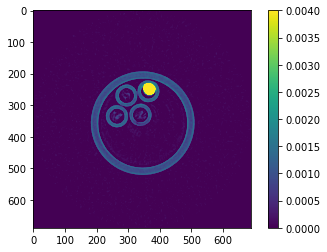

In [45]:
########## tomopy
recon = rocku.recon(proj_tilt, theta, rot_center=rot_center, algorithm='gridrec')
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
plt.imshow(recon[600, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

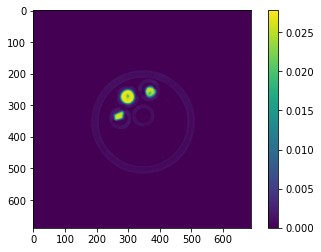

In [46]:
plt.imshow(recon[1260, :, :], vmin=0)
plt.colorbar()
plt.show()

In [47]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm

# Export recon files

In [48]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True)